_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox
    !pip install matplotlib==3.7.1 


# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [2]:
# YOUR CODE HERE

import category_encoders as ce
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [3]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url, index_col='Inspection ID')

**Task 1 Test**

In [4]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [5]:
'''T2. Identify data leakage column.'''
leaky_col = 'Serious Violations Found'

**Task 2 Test**

In [13]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

In [14]:
# Convert Inspection Date to datetime
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [36]:
'''T3. Write wrangle function.'''
def wrangle(df):
    # Remove leaky column
    df = df.drop(columns='Serious Violations Found')
    
    # Remove high-cardinality categorical columns
    high_cardinality = [col for col in df.select_dtypes(include='object').columns
                        if df[col].nunique() > 500]
    df = df.drop(columns=high_cardinality)
    
    # Remove categorical columns with only one category
    one_category = [col for col in df.select_dtypes(include='object').columns
                    if df[col].nunique() == 1]
    df = df.drop(columns=one_category)
    
    # Remove numerical columns that are unique identifiers
    id_cols = ['License #', 'Zip']
    df = df.drop(columns=id_cols)
    
    return df

df = wrangle(df)

In [37]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51916 entries, 2088270 to 114560
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Facility Type    51692 non-null  object        
 1   Risk             51904 non-null  object        
 2   City             51863 non-null  object        
 3   Inspection Date  51916 non-null  datetime64[ns]
 4   Inspection Type  51915 non-null  object        
 5   Latitude         51718 non-null  float64       
 6   Longitude        51718 non-null  float64       
 7   Fail             51916 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 3.6+ MB


**Task 3 Test**

In [39]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [40]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# Split into X and y
X = df.drop(columns=target)
y = df[target]

**Task 4 Test**

In [41]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [42]:
'''T5. Split dataset into training and validation sets.'''
# Split data into training and validation sets based on date of inspections
cutoff = pd.to_datetime('2017-01-01')
train_mask = df['Inspection Date'] < cutoff
val_mask = df['Inspection Date'] >= cutoff

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]

**Task 5 Testing**

In [43]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [44]:
'''T6. Establish baseline accuracy.'''
# Find the proportion of the majority class in the training set
baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [45]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [52]:
'''T7. Build model with bagging predictor.'''
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#Create pipeline with preprocessing and bagging predictor
model_bag = make_pipeline(
SimpleImputer(strategy='most_frequent'),
OneHotEncoder(handle_unknown='ignore'),
RandomForestClassifier(random_state=42)
)

model_bag.fit(X_train, y_train);






**Tast 7 Testing**

In [53]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [54]:
'''T8. Build model with boosting predictor.'''
from sklearn.ensemble import GradientBoostingClassifier

# Define preprocessor
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define model pipeline
model_boost = Pipeline([
    ('preprocessor', preprocessor),
    ('predictor', GradientBoostingClassifier(random_state=42))
])

# Fit model on training data
model_boost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(handle_unknown='ignore'))])),
                ('predictor', GradientBoostingClassifier(random_state=42))])

**Task 8 Testing**

In [55]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [56]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9979200038252803
Validation accuracy: 0.6980870254732877

Boosting Model
Training accuracy: 0.7539388433308628
Validation accuracy: 0.7027455644761622


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

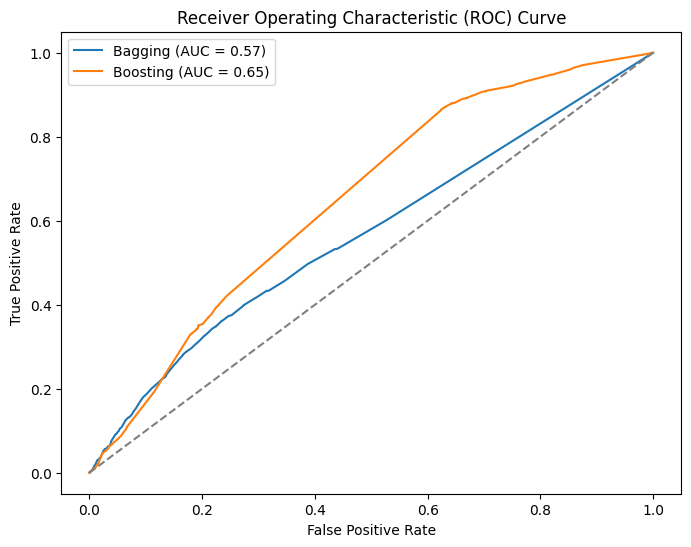

In [57]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

# Get predicted probabilities for both models
y_prob_bag = model_bag.predict_proba(X_val)[:, 1]
y_prob_boost = model_boost.predict_proba(X_val)[:, 1]

# Compute ROC curve and AUC for both models
fpr_bag, tpr_bag, _ = roc_curve(y_val, y_prob_bag)
auc_bag = auc(fpr_bag, tpr_bag)

fpr_boost, tpr_boost, _ = roc_curve(y_val, y_prob_boost)
auc_boost = auc(fpr_boost, tpr_boost)

# Plot ROC curves for both models
fig, ax = plt.subplots(figsize=(8, 6))
display_bag = RocCurveDisplay(fpr=fpr_bag, tpr=tpr_bag, roc_auc=auc_bag, estimator_name='Bagging')
display_bag.plot(ax=ax, name='Bagging')

display_boost = RocCurveDisplay(fpr=fpr_boost, tpr=tpr_boost, roc_auc=auc_boost, estimator_name='Boosting')
display_boost.plot(ax=ax, name='Boosting')

# Plot diagonal line (random classifier)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Set plot title and axis labels
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# Set legend
ax.legend()
plt.show()


**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [58]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report

# Make predictions on validation data using chosen model
y_pred = model_bag.predict(X_val)

# Generate classification report
model_cr = classification_report(y_val, y_pred)

# Print classification report
print(model_cr)


              precision    recall  f1-score   support

           0       0.71      0.96      0.82      7092
           1       0.45      0.08      0.13      2997

    accuracy                           0.70     10089
   macro avg       0.58      0.52      0.47     10089
weighted avg       0.63      0.70      0.61     10089



**Task 10 Testing**

In [59]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [60]:
'''T11. Create DataFrame of permutation importances.'''
from sklearn.inspection import permutation_importance

#Compute feature importances
result = permutation_importance(model_bag, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)

#Create dataframe
permutation_importances = pd.DataFrame({'feature': X_val.columns,
'mean_importance': result['importances_mean'],
'importance_std': result['importances_std']})

permutation_importances = permutation_importances.set_index('feature')

#Sort values by mean importance
permutation_importances = permutation_importances.sort_values('mean_importance', ascending=False)

permutation_importances


,mean_importance,importance_std
feature,,
Inspection Type,0.006621,0.001525
Inspection Date,0.000000,0.000000
City,-0.000099,0.000044
Facility Type,-0.001021,0.001331
Risk,-0.001804,0.001051
Longitude,-0.004520,0.000465
Latitude,-0.004827,0.000585


**Task 11 Testing**

In [61]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

In [ ]:
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
features = ['Longitude', 'Latitude']
# YOUR CODE HERE
raise NotImplementedError()

What do you think? Is there a relationship between location and failing a food saftey inspection? Answer below.

This task will not be autograded - but it is part of completing the challenge.